In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [2]:
def view_imgs(imgs, cols=4):
    """ this function to show a list of imgs using subplot """
    rows = np.ceil(len(imgs)/cols)
    width = imgs[0].shape[1]
    height = imgs[0].shape[0]
    figsize = width/70, height/60
    plt.figure(figsize= figsize)
    for i, img in enumerate(imgs):
        camp = 'gray' if len(img.shape) < 3 else None
        plt.subplot(rows, cols, i+1)
        plt.imshow(img,cmap=camp)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [3]:
dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [4]:
test_imgs = glob.glob('test_images/*.jpg')

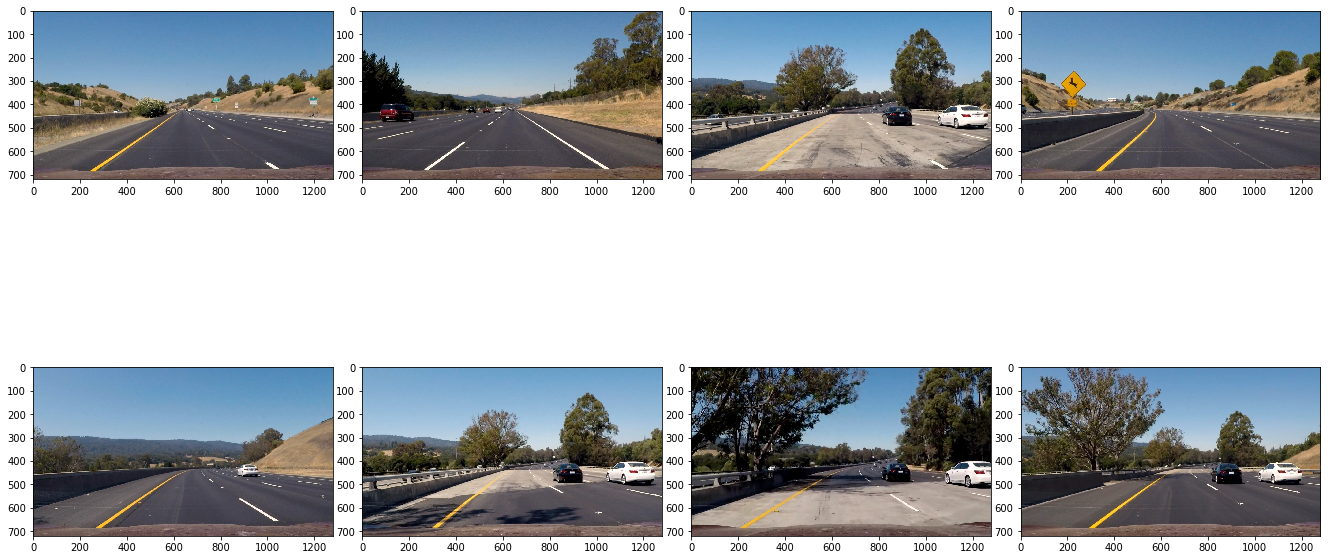

In [5]:
test_undist = []
for indx, img_name in enumerate(test_imgs):
    img = cv2.imread(img_name)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'output_images/test_undist/' + str(indx) + '.jpg'
    cv2.imwrite(write_name,dst)
    test_undist.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
view_imgs(test_undist)

In [6]:
def hls_select(img, thresh=(150, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    binary = np.zeros_like(s)
    binary[(s>thresh[0])&(s<=thresh[1])] = 1
    binary[gray < 20] = 0
    #s[(s>thresh[1])|(s<=thresh[0])] = 0
    return binary

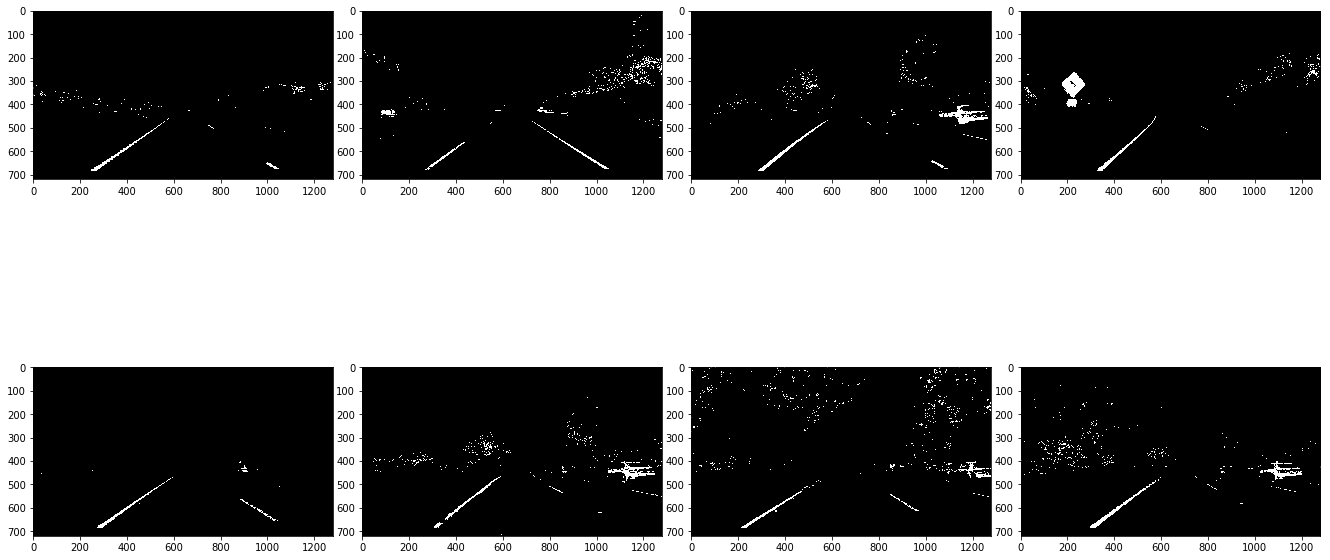

In [7]:
test_color_thresh = []
for indx, img in enumerate(test_undist):
    thresh = hls_select(img)
    write_name = 'output_images/test_color_thresh/' + str(indx) + '.jpg'
    cv2.imwrite(write_name,255*thresh)
    test_color_thresh.append(thresh)
view_imgs(test_color_thresh)

In [8]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3 ,thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) if len(img.shape) > 2 else img 
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) if orient == 'x' else \
            cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) if len(img.shape) > 2 else img 
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel>= mag_thresh[0]) & (scaled_sobel<= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask # Remove this line
    return binary_output

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) if len(img.shape) > 2 else img 
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(absy, absx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >=thresh[0]) & (direction <= thresh[1]) ] =1
    # 6) Return this mask as your binary_output image
    binary_output = mask # Remove this line
    return binary_output

In [11]:
def thresholding(image, ksize = 7, gradx_thresh = (60,255), grady_thresh = (60,255), mag_threshold=(30, 255), dir_thresh = (0.5, 1.1)):
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh = mag_threshold)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1))] = 1
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

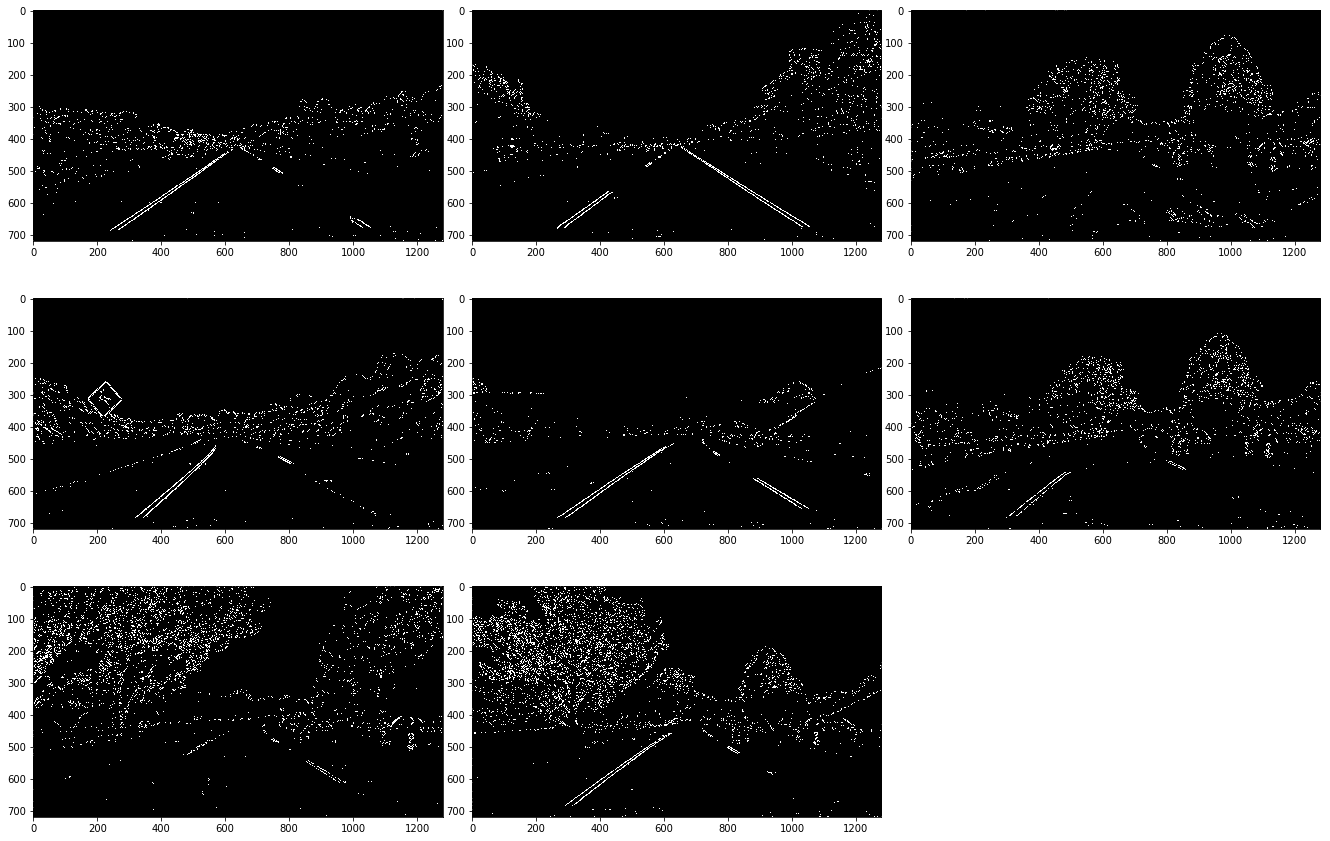

In [12]:
test_undist_thresh = []
for indx, img in enumerate(test_undist):    
    thresh = thresholding(img)
    write_name = 'output_images/test_undist_thresh/' + str(indx) + '.jpg'
    plt.imsave(write_name,255*thresh,cmap ='gray')
    test_undist_thresh.append(thresh)
view_imgs(test_undist_thresh,cols=3)
#plt.figure(figsize=(20,20))
#plt.imshow(test_undist_thresh[6],cmap='gray')

In [24]:
def combine_thresh(thresh_c, thresh_s):
    thresh_s[thresh_c > 0] = 1
    return thresh_s

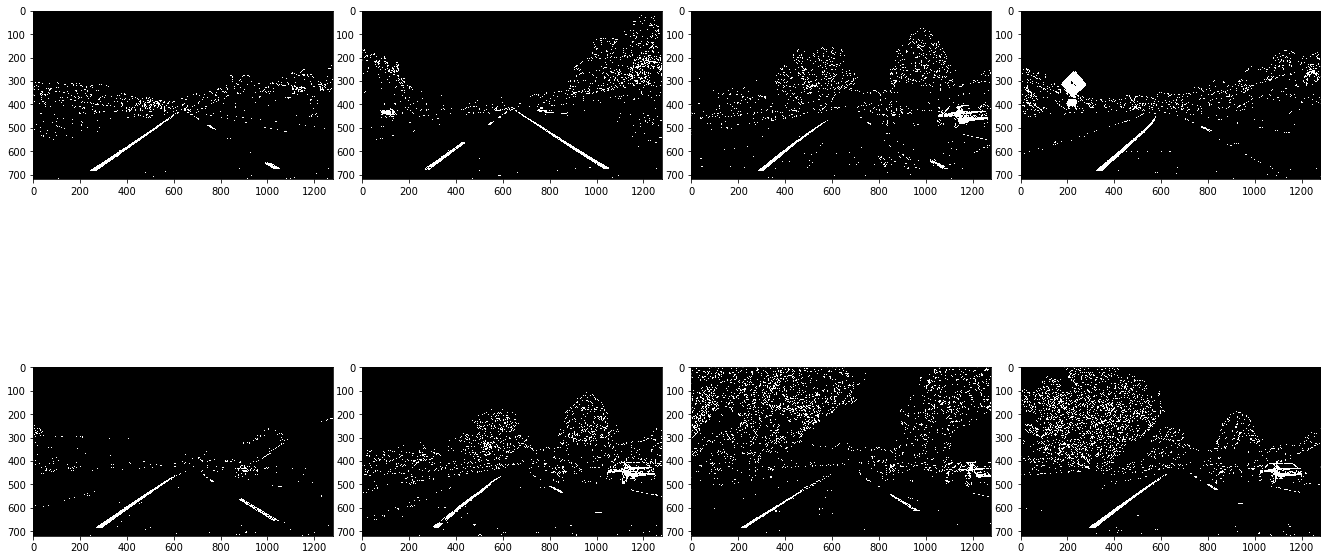

In [13]:
test_all_thresh = []
for indx, img in enumerate(test_undist_thresh):
    img[test_color_thresh[indx]>0] = 1
    write_name = 'output_images/test_all_thresh/' + str(indx) + '.jpg'
    plt.imsave(write_name, 255*img, cmap ='gray')
    test_all_thresh.append(img)
#plt.figure(figsize=(20,20))
#plt.imshow(test_all_thresh[3],cmap='gray')
view_imgs(test_all_thresh)

In [14]:
warp_pickle = pickle.load( open( "warp_pickle.p", "rb" ) )
M = warp_pickle["M"]
INV_M = warp_pickle["INV_M"]

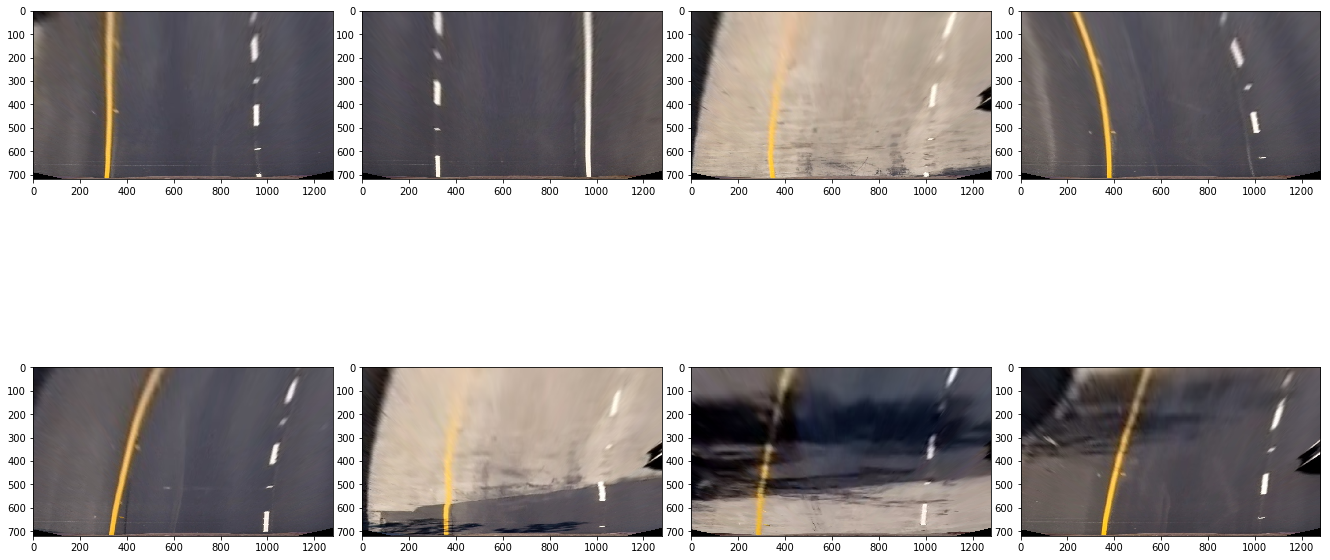

In [15]:
test_unwarped = []
for indx, img in enumerate(test_undist):    
    unwarp = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    write_name = 'output_images/test_unwarped/' + str(indx) + '.jpg'
    plt.imsave(write_name,unwarp)
    test_unwarped.append(unwarp)
view_imgs(test_unwarped)

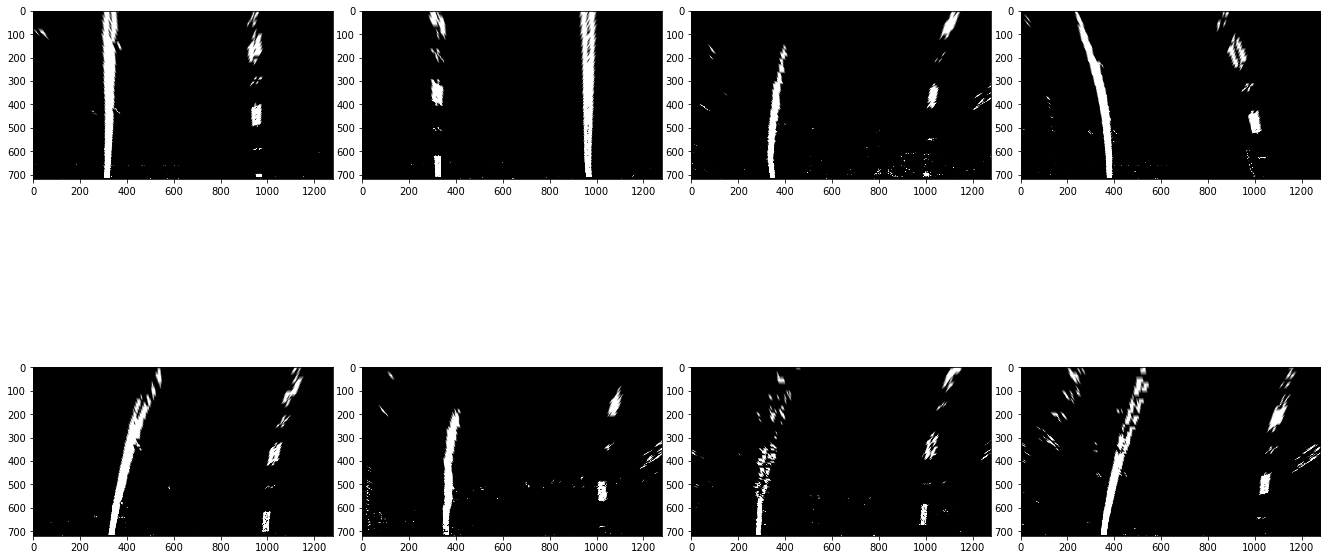

In [16]:
test_all_unwarped = []
for indx, img in enumerate(test_all_thresh):    
    unwarp = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    write_name = 'output_images/test_all_unwarped/' + str(indx) + '.jpg'
    plt.imsave(write_name,unwarp,cmap ='gray')
    test_all_unwarped.append(unwarp)
view_imgs(test_all_unwarped)

In [30]:

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),\
                max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width=50, window_height=80, margin=50, thresh = 50):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset if np.sum(conv_signal[l_min_index:l_max_index]) > thresh else l_center
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset if np.sum(conv_signal[r_min_index:r_max_index]) > thresh else r_center
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [18]:
def draw_windows(warped, window_centroids, window_width, window_height):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    return output


In [19]:
def get_points(warped, window_centroids, window_width, window_height):
    # If we found any window centers

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    lefty, leftx = np.nonzero(np.multiply(l_points, warped))
    righty, rightx = np.nonzero(np.multiply(r_points, warped))
    
    return leftx, lefty, rightx, righty


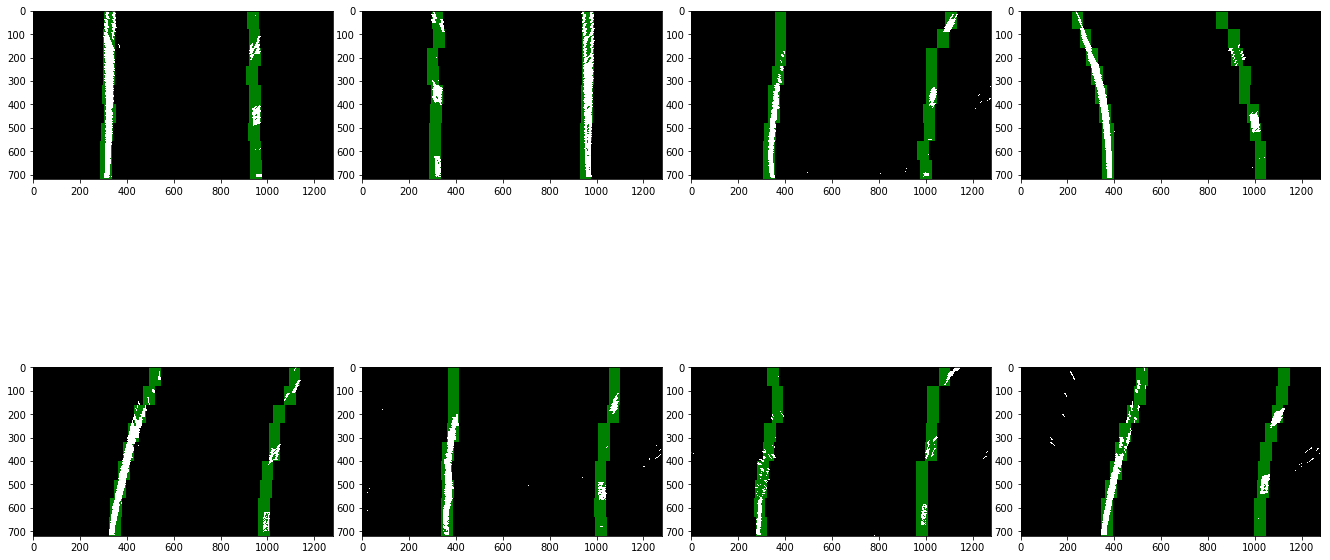

In [20]:
sliding_window = []
for indx, img in enumerate(test_all_unwarped):    
    img = np.array(img,np.uint8)
    write_name = 'output_images/sliding_window/' + str(indx) + '.jpg'
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    drawed = draw_windows(img, window_centroids, window_width, window_height)
    plt.imsave(write_name,drawed)
    sliding_window.append(drawed)
view_imgs(sliding_window)


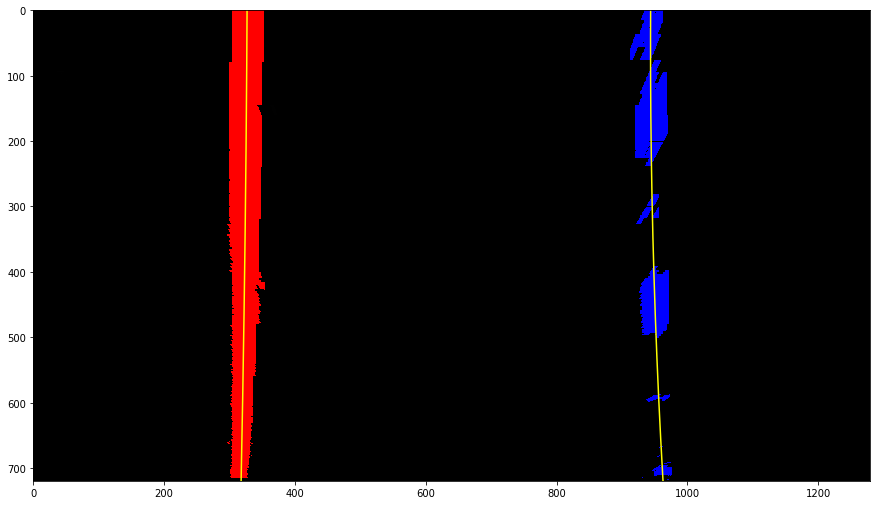

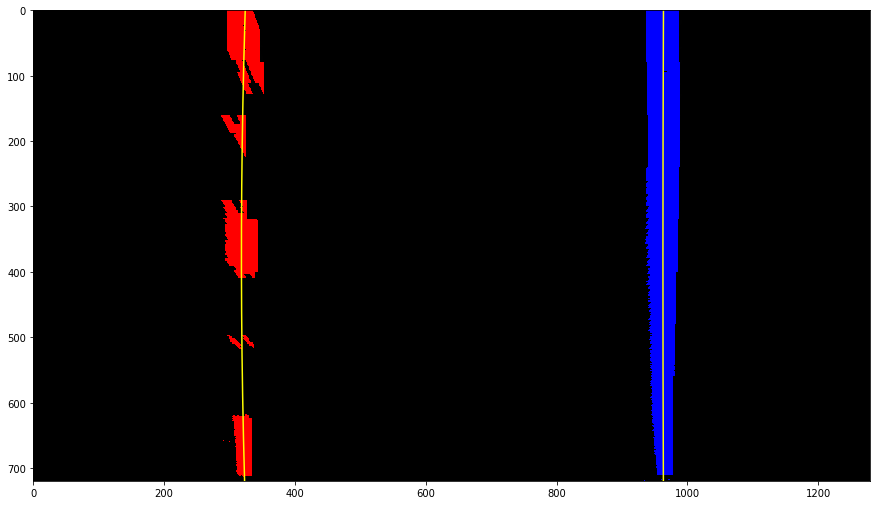

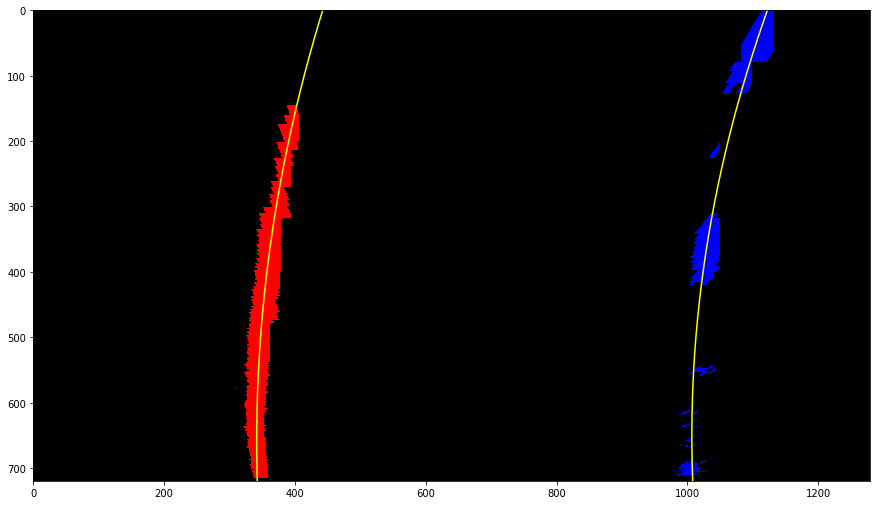

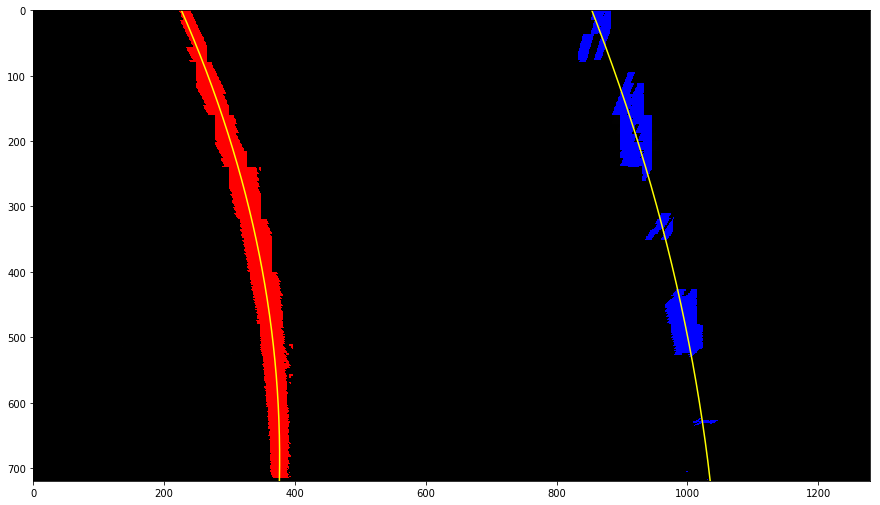

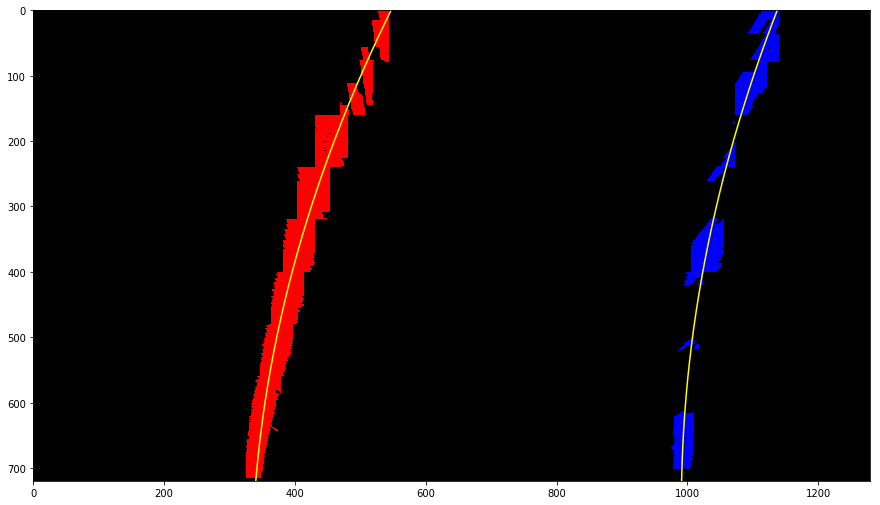

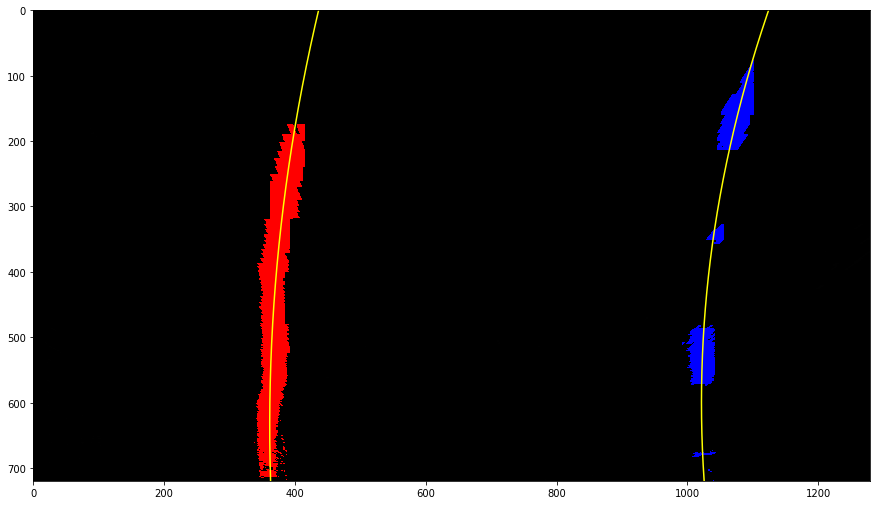

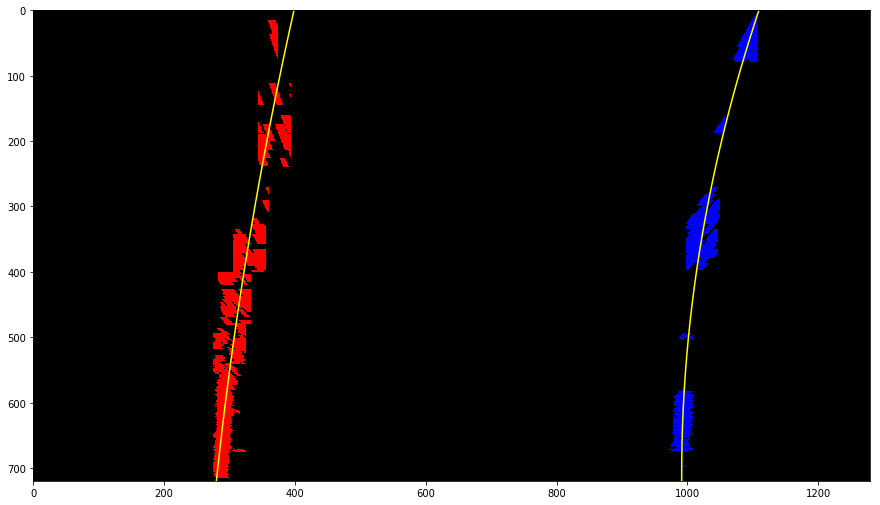

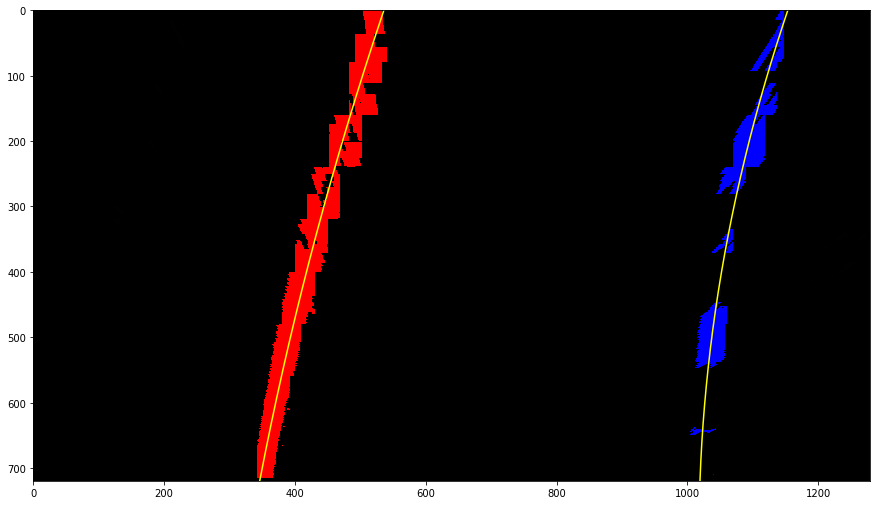

In [21]:
prespective_lines_detected = []
for indx, img in enumerate(test_all_unwarped):    
    img = np.array(img,np.uint8)
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    leftx, lefty, rightx, righty = get_points(test_all_unwarped[indx], window_centroids, window_width, window_height)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.arange(0,img.shape[0])[::-1]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((img,img,img))
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    write_name = 'output_images/prespective_lines_detected/' + str(indx) + '.jpg'
    
    fig = plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    plt.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    fig.savefig(write_name)
    prespective_lines_detected.append(out_img)

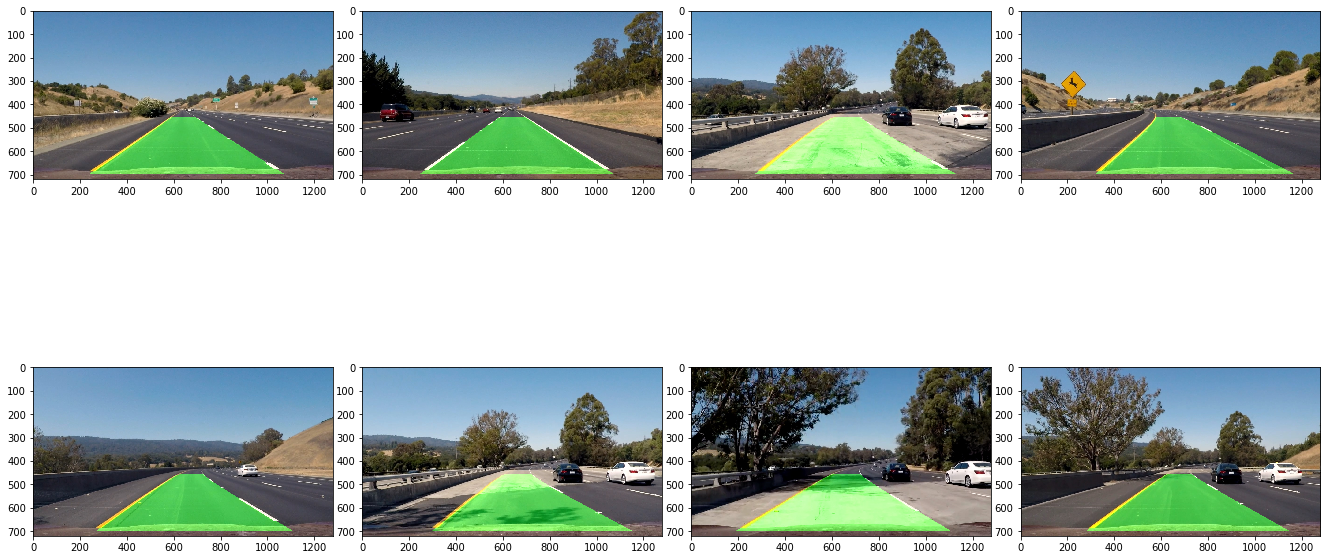

In [22]:
lane_detected = []
for indx, img in enumerate(test_all_unwarped):    
    img = np.array(img,np.uint8)
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    leftx, lefty, rightx, righty = get_points(test_all_unwarped[indx], window_centroids, window_width, window_height)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.arange(0,img.shape[0])[::-1]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane = np.array(np.zeros_like(img), dtype=np.int32)
    lane += np.arange(img.shape[1]).reshape(1,-1)
    lane[(lane < left_fitx.reshape(-1,1))[::-1] | (lane > right_fitx.reshape(-1,1))[::-1]] = 0
    lane[lane > 0]  = 255
    lane = np.array(lane,np.uint8)
    
    lane = np.dstack((np.zeros_like(lane),lane,np.zeros_like(lane)))
    
    lane = cv2.warpPerspective(lane, INV_M, lane.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    output = cv2.addWeighted(test_undist[indx], 1, lane, 0.5, 0.0)
    
    write_name = 'output_images/lane_detected/' + str(indx) + '.jpg'
    #fig = plt.figure(figsize=(15,15))
    #ax = plt.subplot(111)
    #plt.imshow(out_img)
    #plt.imshow(output)
    #ax.plot(left_fitx, ploty, color='yellow')
    #ax.plot(right_fitx, ploty, color='yellow')
    #fig.savefig(write_name)
    plt.imsave(write_name,output)
    
    lane_detected.append(output)
view_imgs(lane_detected)

In [46]:
def process_image(img, prev_lane, dist, mtx, window_width=50, window_height=80, margin=50, thresh=50):
    
    ## undistortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #color thresholding
    thresh_c = hls_select(undist)
    
    #abs, mag and direction thresholdings
    thresh_s = thresholding(undist)
    
    #combined threshold
    comb = combine_thresh(thresh_c, thresh_s)
    
    #unwarping
    unwarp = cv2.warpPerspective(comb, M, comb.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    #find windows centroids
    window_centroids = find_window_centroids(unwarp, window_width, window_height, margin, thresh)
    
    #get points
    leftx, lefty, rightx, righty = get_points(unwarp, window_centroids, window_width, window_height)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_width = right_fitx - left_fitx
    if  np.max(lane_width) - np.min(lane_width) < 50 :
        #prepare lane green mask
        lane = np.array(np.zeros_like(unwarp), dtype=np.int32)
        lane += np.arange(unwarp.shape[1]).reshape(1,-1)
        lane[(lane < left_fitx.reshape(-1,1))[::-1] | (lane > right_fitx.reshape(-1,1))[::-1]] = 0
        lane[lane > 0]  = 255
        lane = np.array(lane,np.uint8)
        lane = np.dstack((np.zeros_like(lane),lane,np.zeros_like(lane)))

        #warp the lane mask to the original view
        lane = cv2.warpPerspective(lane, INV_M, lane.shape[1::-1], flags=cv2.INTER_LINEAR)

    else:
        lane = prev_lane
        
    output = cv2.addWeighted(undist, 1, lane, 0.5, 0.0)
    return lane, output

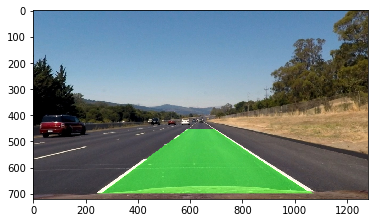

In [49]:
plt.imshow(process_image(test_undist[1], dist, mtx))

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [55]:
output = 'test_videos_output/project_video.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(lambda img: process_image(img,dist,mtx)) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [19:18<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 19min 20s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [23]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    y_eval *= ym_per_pix
    left_curverad = ( 1 + (2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the right line here

    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

NameError: name 'generate_data' is not defined